# ***Random Forrest***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
## Librerias a usar.
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import statsmodels.formula.api  as smf
import warnings
##
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import accuracy_score, roc_curve, auc, accuracy_score 
from sklearn.metrics         import plot_confusion_matrix, confusion_matrix
from collections             import defaultdict
##
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"
url_book="https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/"

## ***Bagging y Random Forrest***

Supongamos que hace una pregunta compleja a miles de personas al azar y luego agrega las respuestas, en muchos casos se encontrará que la respuesta agregada es mejor que la respuesta de un experto esto es llamado _sabiduría de la multitud_ [(wisdom of the crowd)](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd). Ahora, pensando en el _machine learning_, si agregamos las predicciones de un grupo de predictores (clasificador o regresores) a menudo se obtiene mejores predicciones que con el mejor predictor original. Un grupo de predictores se denomina _ensemble_; luego, esta técnica se denomina _Ensemble Learning_.

Por ejemplo, puede entrenar un grupo de clasificadores _DecisionTree_, cada uno en un subconjunto aleatorio del set de train. Para hacer predicciones, solo se obtienen las predicciones de todos los árboles individuales, luego ***se predice la clase que obtiene la mayor cantidad de votos***. Tal conjunto de árboles de decisión se llama Random Forest, y a pesar de su sencillez, es uno de los más potentes algoritmos de Machine Learning disponibles en la actualidad.

***NOTA:***

Ensemble methods funcionan mejor cuando los predictores son lo más independientes posible entre sí. Una forma de obtener clasificadores diversos es entrenarlos usando algoritmos muy diferentes. Esto aumenta la posibilidad de que cometan muy diferentes tipos de errores, mejorando la precisión del conjunto.

### ***Bagging y pasting.***

Una forma de obtener un conjunto diverso de clasificadores es usar algoritmos de entrenamiento muy diferentes. Otro enfoque es usar el mismo algoritmo de entrenamiento para todo predictor y entrenarlos en diferentes subconjuntos aleatorios del set de train. Cuando el muestreo se realiza con reemplazo, este método se llama _bagging_ (bootstrap-aggregating). Cuando el muestreo se realiza sin reposición, es llamado _pasting_.

Tanto en _bagging_ como en _pasting_ se permiten muestrear registros del set de train varias veces a través de múltiples predictores, pero solo el _bagging_ permite a los registro del set de train muestrearse varias veces para el mismo predictor.

Una vez que se entrenan todos los predictores, el _ensemble_ puede hacer una predicción para un nuevo registro simplemente agregando las predicciones de todos los predictores. La _aggregation function_ es normalmente la MODA estadística (es decir, la predicción más frecuente) para la clasificación, o el promedio para la regresión. Cada predictor individual tiene un mayor sesgo que si se entrenara en el set de train original, pero la agregación reduce tanto el sesgo como la varianza. Generalmente, el resultado neto es que el conjunto tiene un sesgo similar pero una varianza menor que un solo predictor entrenado en el set de train  original.

### ***Algorítmo Bagging***

Supongamos que tenemos una respuesta $Y$ y $P$ variables predictoras $\mathbf{X}=X_1,X_2,...,X_p$ con $n$ registros. _Bagging_ es se forma del algoritmo básico para ensembles, excepto que, en lugar de ajustar varios modelos a la misma data, cada nuevo modelo se ajusta a un remuestreo bootstrap.

***Algorítmo:***

1. Inicialice $M$, el número de modelos a ajustar, y $N$, el número de registros a elegir ($N< n$). Establezca la iteración $m= 1$.

2. Tome una nueva bootstrap resample (es decir, con reemplazo) de $N$ registros del set de train para formar una submuestra $Y_m$ y $\mathbf{X}_m$ (the bag).

3. Entrene un modelo usando $Y_m$ y $\mathbf{X}_m$ para crear un conjunto de reglas de decisión $\hat{f}_m(\mathbf{X})$.

4. Incremente el contador del modelo $m=m+1$. Si $m\leq M$, vaya al paso 2.

En el caso de que $\hat{f}_m$ prediga la probabilidad de que $Y=1$, la estimación bagged viene dada por:


$$\hat{f}=\frac{1}{M}\left(\hat{f_1}(\mathbf{X})+\hat{f_2}(\mathbf{X})+\cdots+\hat{f_M}(\mathbf{X})\right)$$

### ***Out-of-Bag Evaluation***

Con _bagging_, algunas instancias se pueden muestrear varias veces para cualquier predictor dado, mientras que otros pueden no ser muestreados en absoluto. Por defecto, un _BaggingClassifier_ toma $m$ registros del set de train con reemplazo (`bootstrap=True`), donde $m$ es el tamaño del conjunto de entrenamiento. Esto significa que solo alrededor del $63\%$ de los registros del set de entrenamiento se muestrean en promedio para cada predictor. El $37\%$ restante de los registros  que no son muestreados se denominan registros (instancias) ***out-of-bag (oob)***.

Dado que un predictor nunca ve los registros _oob_ durante el entrenamiento, se puede evaluar en
estos registros, sin la necesidad de un set de validación por separado. Es posible evaluar el _ensamble_ promediando las evaluaciones _oob_ de cada predictor.



***NOTA:***

1. En Scikit-Learn, puede establecer `oob_score=True` al crear un _BaggingClassifier_ para solicitar una evaluación _oob_ automática después del entrenamiento.

2. La función de decisión _oob_ para cada registro del set de train también está disponible a través del atributo `oob_decision_function_`. En este caso que el estimador base tenga un método como `predict_proba()`, la función de decisión devuelve las probabilidades de clase para cada registro del set de train.

### ***Random Forrest.***

_Random Forrest_ es un _ensemble_ basado en _bagging_ de _DecisionTrees_, con una imporrtante extensión: además de muestrear los registros del set de train también muestrea las features. En los _DecisionTree_ tradicionales, para determinar cómo crear una subpartición de un partición $A$, el algoritmo elige la variable y el punto de división minimizando un criterio como la impureza de Gini. Con Random Forrest, en cada etapa del algoritmo, la elección de la feature es _limitada a un subconjunto aleatorio de features._

***NOTA:***

1. Generalmente se entrena con `max_samples` ajustado al tamaño del set de train.

2. Una regla empírica es elegir $\sqrt{P}$ donde $P$ es el número de variables predictoras. 


### ***Algoritmo Random Forrest.***

En comparación con el algoritmo de DecisionTree, el algoritmo de Random Forrest agrega dos pasos más: el bagging y el bootstrap sampling de features en cada división:

1. Tome una submuestra de  bootstrap  (con reemplazo) de los registros.

2. Para la primera división, muestree $p< P$ variables al azar sin reemplazo.

3. Para cada una de las variables muestreadas $X_{j(1)}, X_{j(2)},⋯,X_{j(p)}$, aplicar el siguiente algortimo de división:
    
  ***a.*** Para cada valor $s_{j(k)}$ de $X_{j(k)}$:
  
  i. Divida los registros en la partición $A$, con     $X_{j(k)}< s_{j(k)}$ como una partición y los registros restantes donde $X_{j(k)}≥ s_{j(k)}$ como otra partición.

  ii. Mida la homogeneidad de las clases dentro de cada subpartición de A.

  ***b.*** Seleccione el valor de $s_{j(k)}$ que produce la máxima homogeneidad dentro de la partición
de clase.

4. Seleccione la variable $X_{j(k)}$ y el valor de división $s_{j(k)}$ que produce la máxima homogeneidad de clase dentro de la partición.

5. Continúe con la siguiente división y repita los pasos anteriores, comenzando con el paso 2.

6. Continúe con divisiones adicionales, siguiendo el mismo procedimiento hasta el árbol logre se máximo crecimiento.

7. Vuelva al paso 1, tome otra submuestra de arranque y comience el proceso de nuevo otra vez.

## ***Nuevo modelo de incumplimiento de pago.***

***Problema:***  Construir un modelo de clasificación para determinar si un usuario  pagará su préstamo o no.

Nuestra data de trabajo.

In [2]:
df = pd.read_csv(url_base + "Logistic_Regression_1.csv",
                 dtype = {"loan_status":"category", "annual_inc":"float",
                          "verification_status":"category", "emp_length":"category",
                          "home_ownership":"category", "int_rate":"object",
                          "loan_amnt":"float", "purpose":"category",
                          "term":"category", "grade":"category"})
df["int_rate"] = df["int_rate"].str.rstrip("%").astype("float")

### ***Random Forrest buscando mejorar Decisicion Tree***

Vamos a ajustar un clasificador Random Forrest con las covariables `term` y `annual_inc` y generemos la curva ROC asociada.

In [3]:
## Preparamos la data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
##
df_rf = df.copy()
X1 = df_rf[["annual_inc","term"]]
X1 = pd.get_dummies(X1)
y = df_rf[["loan_status"]]

In [4]:
## Instanciamos un RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100,
                                max_depth=2,
                                random_state=0)
## Ajustamos el modelo.
clf_rf.fit(X1,y)

RandomForestClassifier(max_depth=2, random_state=0)

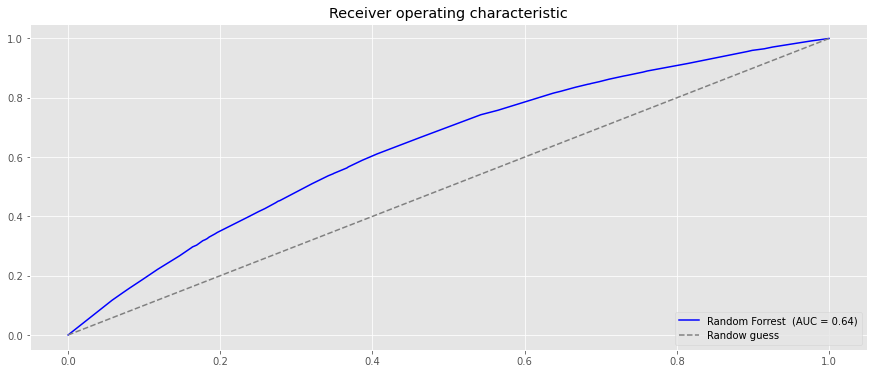

In [5]:
## Curva de ROC RandomForestClassifier
probas1 = clf_rf.predict_proba(X1)[:,1]
y_encoding = encoder.fit_transform(y)
fpr, tpr, _ = roc_curve(y_encoding, probas1)
roc_auc1 = auc(fpr, tpr)
##
plt.plot(fpr,tpr,label = "Random Forrest  (AUC = {:.2f})".format(roc_auc1), color = "blue")
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

Podemos ver que hay un aumento en AUC usando el algoritmo de bosque aleatorio. Con solo dos covariables, podemos lograr un aumento bastante significativo en el rendimiento. Esta diferencia probablemente sería más pronunciada con más variables.

## ***Modelo con todas las covariables***

In [6]:
df_full = df.copy()
X, y = df_full.drop(columns = ["loan_status"]), df_full[["loan_status"]]
X = pd.get_dummies(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=123)

In [8]:
clf_rf_full = RandomForestClassifier(n_estimators=100,
                                     max_depth=3,
                                     random_state=0)
clf_rf_full.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, random_state=0)

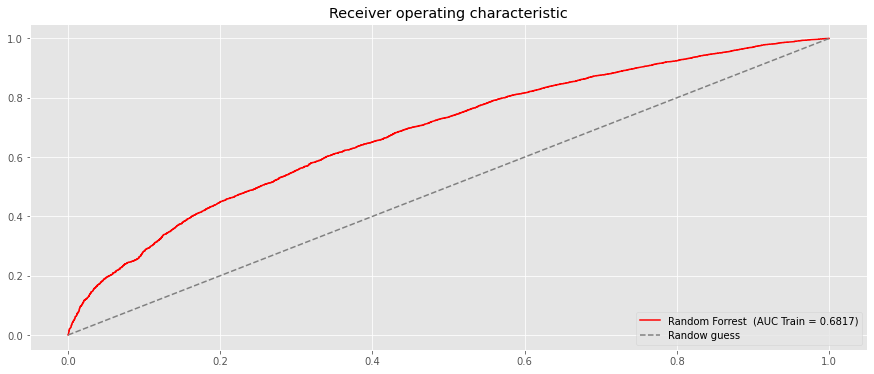

In [9]:
## Curva de ROC en el set de Train.
probas1 = clf_rf_full.predict_proba(X_train)[:,1]
y_encoding = encoder.fit_transform(y_train)
fpr, tpr, _ = roc_curve(y_encoding, probas1)
roc_auc1 = auc(fpr, tpr)
##
plt.plot(fpr,tpr,label = "Random Forrest  (AUC Train = {:.4f})".format(roc_auc1), color = "r")
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

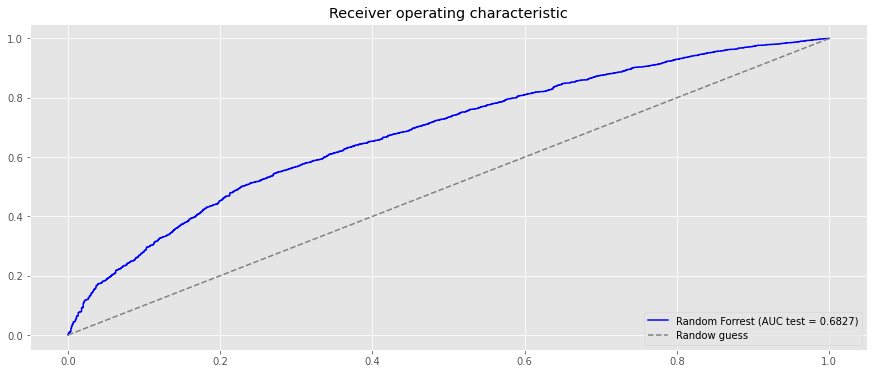

In [10]:
## Curva de ROC en el set de test.
probas_test = clf_rf_full.predict_proba(X_test)[:,1]
y_encoding_test = encoder.fit_transform(y_test)
fpr_test, tpr_test, _ = roc_curve(y_encoding_test, probas_test)
roc_auc_test = auc(fpr_test, tpr_test)
##
plt.plot(fpr_test,tpr_test,label = "Random Forrest (AUC test = {:.4f})".format(roc_auc_test),color = "b")
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV
base_estimator = RandomForestClassifier()
##
params = {"max_depth":[n for n in range(2,21)], "criterion":["gini","entropy"], 
          "min_samples_split" : [300 + 100*n for n in range(0,28)],
          "n_estimators":[n for n in range(10,101)]}
###       
clf = RandomizedSearchCV(base_estimator, params, scoring="roc_auc", cv = 5, n_jobs=-1)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_estimators': 98,
 'min_samples_split': 300,
 'max_depth': 20,
 'criterion': 'entropy'}

In [12]:
a = {'n_estimators': 33,
 'min_samples_split': 400,
 'max_depth': 15,
 'criterion': 'gini'}

In [13]:
clf_best = RandomForestClassifier(n_estimators = 33,
                                  min_samples_split = 400,
                                  max_depth = 15 )
clf_best.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, min_samples_split=400, n_estimators=33)

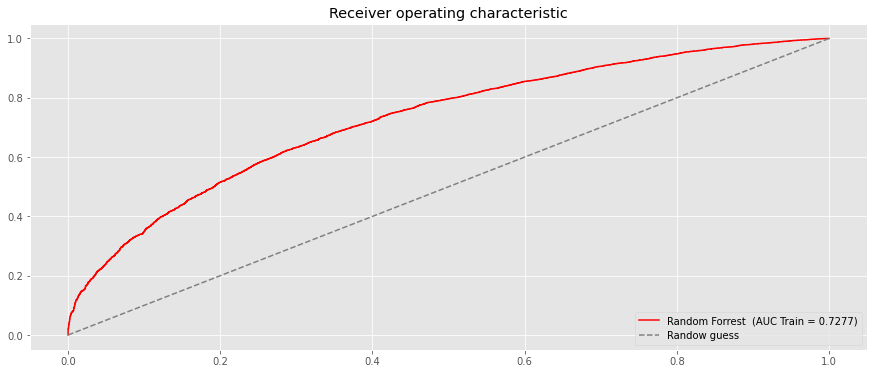

In [14]:
## Curva de ROC en el set de Train.
probas1 = clf_best.predict_proba(X_train)[:,1]
y_encoding = encoder.fit_transform(y_train)
fpr, tpr, _ = roc_curve(y_encoding, probas1)
roc_auc1 = auc(fpr, tpr)
##
plt.plot(fpr,tpr,label = "Random Forrest  (AUC Train = {:.4f})".format(roc_auc1), color = "r")
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

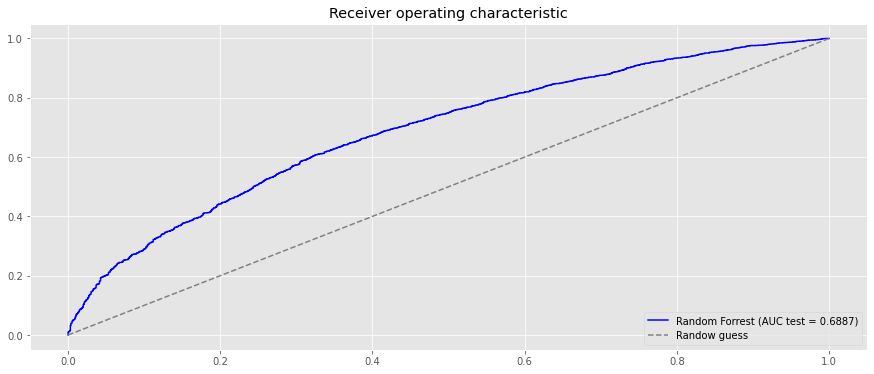

In [15]:
## Curva de ROC en el set de test.
probas_test = clf_best.predict_proba(X_test)[:,1]
y_encoding_test = encoder.fit_transform(y_test)
fpr_test, tpr_test, _ = roc_curve(y_encoding_test, probas_test)
roc_auc_test = auc(fpr_test, tpr_test)
##
plt.plot(fpr_test,tpr_test,label = "Random Forrest (AUC test = {:.4f})".format(roc_auc_test),color = "b")
plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()